In [ ]:
! pip install falconn==1.3.1
!pip install faiss-gpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 59.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for falconn: filename=FALCONN-1.3.1-cp310-cp310-linux_x86_64.whl size=14922876 sha256=b27999c23769b7273b9173dd3096781fbde7f91f0505165c5d90b887d99f5664
  Stored in directory: /root/.cache/pip/wheels/0b/4a/bc/68ac1e3cd3f263c47dfde8586fc3fdf704014ee3db0e5eb651
Successfully built falconn
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 26.7 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, TensorDataset, DataLoader
import torchvision
from torchvision import transforms
import matplotlib
import matplotlib.pyplot as plt
import pickle
import numpy as np
import falconn
import faiss
import platform
import enum
import copy
from bisect import bisect_left
import warnings
import numpy
from itertools import cycle

from sklearn.model_selection import train_test_split
import pandas as pd
import csv

print('python version:      {}'.format(platform.python_version()))
print('torch version:       {}'.format(torch.__version__))
print('torchvision version: {}'.format(torchvision.__version__))
print('numpy version:       {}'.format(np.__version__))
print('matplotlib version:  {}'.format(matplotlib.__version__))
print('pickle version:      {}'.format(pickle.format_version))

use_cuda = torch.cuda.is_available()
print('CUDA available:      {}'.format(use_cuda))
print('cuDNN enabled:       {}'.format(torch.backends.cudnn.enabled))
print('num gpus:            {}'.format(torch.cuda.device_count()))

if use_cuda:
    print('gpu:                 {}'.format(torch.cuda.get_device_name(0)))

python version:      3.10.12
torch version:       2.4.1+cu121
torchvision version: 0.19.1+cu121
numpy version:       1.26.4
matplotlib version:  3.7.1
pickle version:      4.0
CUDA available:      True
cuDNN enabled:       True
num gpus:            1
gpu:                 NVIDIA A100-SXM4-40GB


Put CUDNN to deterministic and set seed values for [reproducibility reasons](https://pytorch.org/docs/stable/notes/randomness.html).

In [ ]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

random_seed = 1
torch.manual_seed(random_seed)
np.random.seed(random_seed)

Let's set some parameters for the Deep kNN.

In [ ]:
num_epochs = 100         # number of training epochs
batch_size_train = 1000  # batch size for training
batch_size_test =500  # batch size for testing
learning_rate = 0.001     # learning rate for training
calibset_size = 1000    # size of the calibration set for DkNN
neighbors = 128          # number of nearest neighbors for DkNN
number_bits = 17          # number of bits for LSH for DkNN

log_interval = 10         # printing training statistics after 10 iterations

## Data

Define data transform functions for training and test set.

In [ ]:
## My data

################ import oversampled beam index #################
DIR = '/content/drive/MyDrive/datasets/FINAL_datasets/'
# filename = DIR + "dataset_Nr_Boston5G.csv"
filename = DIR + "dataset_01_new.csv"  #   used to generate the 01 credibility plots

raw_data = open(filename, "rt")
original_data= numpy.loadtxt(raw_data,delimiter=",")

train, test = train_test_split(original_data, test_size=0.4, random_state=42, shuffle=True)

numpy.savetxt('/content/drive/MyDrive/datasets/FINAL_datasets/train.csv', train, delimiter=",")
numpy.savetxt(DIR + 'test.csv', test, delimiter=",")

filename = DIR + "train.csv"
raw_data = open(filename, "rt")
trainset= numpy.loadtxt(raw_data,delimiter=",")

filename = DIR + "test.csv"
raw_data = open(filename, "rt")
test_data= numpy.loadtxt(raw_data,delimiter=",")

testset_size = len(test_data)
testset_size = testset_size - calibset_size

trainset=trainset

test_data=test_data
print(test_data.shape)

testset, calibset = train_test_split(test_data, test_size=calibset_size, random_state=42, shuffle=True)

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

class CustomDataset(Dataset):
    def __init__(self, datafile, transform=None):
        self.transform = transform
        self.data = pd.DataFrame(datafile)

        # Extract features and labels
        features = self.data.iloc[:, :-1].to_numpy()
        scale_factor = 1  # Example factor to scale up the values
        features = self.data.iloc[:, :-1].to_numpy() * scale_factor

        labels = self.data.iloc[:, -1:].to_numpy()

        # #Standardize the features
        # scaler = StandardScaler()  # Standardization to zero mean and unit variance
        # # # # scaler = MinMaxScaler(feature_range=(0.5, 1))
        # features = scaler.fit_transform(features)

        # Convert to tensors
        self.dataset = torch.tensor(features, dtype=torch.float32)

        # Reshape dataset if needed
        sample_size = len(self.dataset[:, 0])
        # self.dataset = self.dataset.reshape(sample_size, 1, 8, 4)  # Adjust according to your needs  --> for boston
        self.dataset = self.dataset.reshape(sample_size, 1, 8, 4)  # for beeam sensing --> dataset_01

        # Prepare labels
        self.labels = torch.tensor(labels, dtype=torch.long).reshape(-1)
        self.labels = torch.sub(self.labels, 1)  # Convert to zero-based indexing

    def __getitem__(self, idx):
        return self.dataset[idx], self.labels[idx]

    def __len__(self):
        return len(self.dataset)

    def print_sample(self, num_samples):
        for i in range(num_samples):
            print(f"Sample {i}:")
            print("Input (features):", self.dataset[i].numpy())
            print("Output (label):", self.labels[i].item())
            print("-" * 20)




# Create our dataset
trainset=CustomDataset(trainset)
# trainset.print_sample(num_samples=2)
testset=CustomDataset(testset)
calibset=CustomDataset(calibset)

#create a dataloader
trainloader=DataLoader(trainset,batch_size=batch_size_train, num_workers=0, shuffle=True)
testloader=DataLoader(testset,batch_size=batch_size_test, num_workers=0, shuffle=False)
calibloader=DataLoader(calibset ,batch_size=calibset_size, num_workers=0, shuffle=False)




batch_x, batch_y = next(iter(trainloader))  # get first batch
print(batch_y.shape)

print('trainset size beam index: {}'.format(len(trainloader.dataset)))
print('testset size beamindex:  {}'.format(len(testloader.dataset)))
print('calibset size beamindex: {}'.format(len(calibloader.dataset)))


(6000, 33)
torch.Size([1000])
trainset size beam index: 9000
testset size beamindex:  5000
calibset size beamindex: 1000


17.7630833140679

Define training and test set.

### Load Data

## Define Training and Test Functions

Let's define the functions for training and testing.

In [ ]:
def train(num_epochs, model, optim, crit, train_loader, test_loader):
    train_losses = []
    test_losses = []
    train_loss_hist = []
    train_accs_hist=[]
    test_accs = []

    for epoch in range(1, num_epochs + 1):
        model, train_losses, train_loss_hist, train_accs_hist = train_one_epoch(epoch, model, optim, crit, train_loader, train_losses, train_loss_hist, train_accs_hist)
        test_losses, test_accs = test(model, crit, test_loader, test_losses, test_accs)

    print('Finished Training')
    return train_losses, test_losses, test_accs, train_loss_hist, train_accs_hist


def train_one_epoch(epoch_num, model, optim, crit, data_loader, losses, train_loss_hist, train_accs_hist ):
    model.train()
    running_loss = 0.0
    correct = 0

    for batch_idx, data in enumerate(data_loader):
        # Get the inputs; data is a list of [inputs, labels]
        inputs, targets = data
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()

        # Zero the parameter gradients
        optim.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs)
        # print('outputs shape is',outputs.shape)
        loss = crit(outputs, targets)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == targets).sum().item()
        # correct += (output.argmax(dim=1) == targets).sum().item()/var_y_batch.shape[0]

        # Print statistics
        running_loss += loss.item()

        if batch_idx % log_interval == 0:
            dataset_size = len(data_loader.dataset)
            used_samples = batch_idx * len(inputs)
            train_progress = 100. * batch_idx / len(data_loader)
            avg_batch_loss = running_loss / log_interval

            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch_num, used_samples, dataset_size, train_progress, avg_batch_loss
            ))

            losses.append(avg_batch_loss)
            # running_loss = 0.0
    running_loss /= dataset_size
    train_acc= 100. * correct / dataset_size

    train_loss_hist.append(running_loss)
    train_accs_hist.append(train_acc)

    return model, losses, train_loss_hist, train_accs_hist




def test(model, crit, data_loader, test_losses, test_accs):
    model.eval()
    correct = 0
    test_loss = 0

    with torch.no_grad():
        for data in data_loader:
            # Get the inputs; data is a list of [inputs, labels]
            inputs, targets = data

            if use_cuda:
              inputs, targets = inputs.cuda(), targets.cuda()

            # Forward + loss + correct
            outputs = model(inputs)
            test_loss += crit(outputs, targets).item()

            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == targets).sum().item()

    dataset_size = len(data_loader.dataset)
    test_loss /= dataset_size
    acc = 100. * correct / dataset_size

    test_losses.append(test_loss)
    test_accs.append(acc)

    print('\nTest set: Avg. loss: {:.6f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, dataset_size, acc
    ))

    return test_losses, test_accs

## Network Architecture

## Model Training

In [ ]:

# outputlayer_size=int(original_data[: , -1:].max())
outputlayer_size=128
class DEEPNET(nn.Module):
    def __init__(self,outputlayer_size):
        super(DEEPNET, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU(True)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU(True)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=1, stride=1, padding=0)
        self.relu3 = nn.ReLU(True)
        self.fc = nn.Linear(128*8*4, outputlayer_size)

    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        x = self.relu3(self.conv3(x))
        # x = x.view(-1, 128)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x




Let's train the model.

In [ ]:
####### Create Model
model = DEEPNET(outputlayer_size)

if use_cuda:
    model.cuda()
    print('Using ', torch.cuda.device_count(), ' GPU(s)')

# Define Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Start Training
train_losses, test_losses, accs,  train_loss_hist, train_accs_hist = train(num_epochs, model, optimizer, criterion, trainloader, testloader)

print()
print('Testing Accuracies: {}'.format(accs))

print('Train_loss_history:',train_loss_hist)
print('train_accs_hist:',train_accs_hist)





Using  1  GPU(s)
Train Epoch: 1 [0/9000 (0%)]	Loss: 0.484857

Test set: Avg. loss: 0.004031, Accuracy: 1497/5000 (29.94%)

Train Epoch: 2 [0/9000 (0%)]	Loss: 0.202618

Test set: Avg. loss: 0.002914, Accuracy: 2343/5000 (46.86%)

Train Epoch: 3 [0/9000 (0%)]	Loss: 0.142955

Test set: Avg. loss: 0.002363, Accuracy: 2694/5000 (53.88%)

Train Epoch: 4 [0/9000 (0%)]	Loss: 0.117965

Test set: Avg. loss: 0.001986, Accuracy: 3114/5000 (62.28%)

Train Epoch: 5 [0/9000 (0%)]	Loss: 0.101452

Test set: Avg. loss: 0.001704, Accuracy: 3441/5000 (68.82%)

Train Epoch: 6 [0/9000 (0%)]	Loss: 0.083639

Test set: Avg. loss: 0.001538, Accuracy: 3568/5000 (71.36%)

Train Epoch: 7 [0/9000 (0%)]	Loss: 0.079644

Test set: Avg. loss: 0.001291, Accuracy: 3855/5000 (77.10%)

Train Epoch: 8 [0/9000 (0%)]	Loss: 0.066827

Test set: Avg. loss: 0.001093, Accuracy: 4052/5000 (81.04%)

Train Epoch: 9 [0/9000 (0%)]	Loss: 0.052591

Test set: Avg. loss: 0.001047, Accuracy: 4137/5000 (82.74%)

Train Epoch: 10 [0/9000 (0%)]

Put model in evaluation mode.

Let's test our model again to see again which accuracy we have finally reached.

In [ ]:
def test_final(model, data_loader):
    _, accs = test(model, criterion, data_loader, [], [])
    return accs[0]

In [ ]:
test_acc = test_final(model, testloader);



Test set: Avg. loss: 0.000205, Accuracy: 4821/5000 (96.42%)



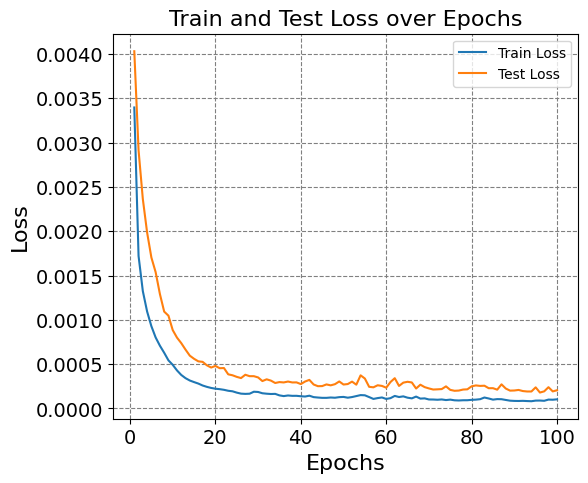

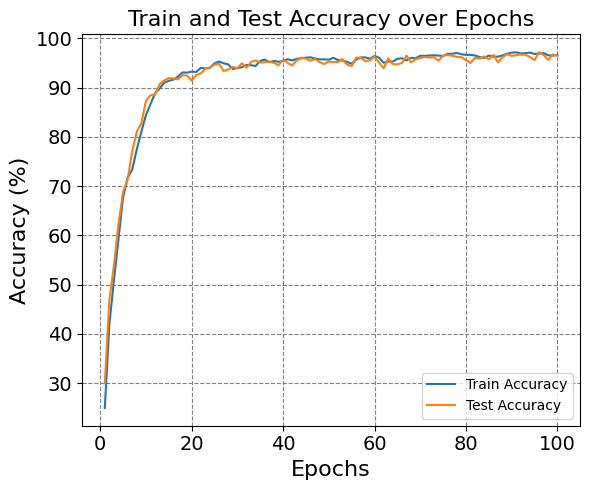

In [ ]:
def plot_train_test_metrics(train_loss_hist, test_loss_hist, train_accs_hist, test_accs_hist, num_epochs):
    epochs = range(1, num_epochs + 1)

    # Plotting Loss
    plt.figure(figsize=(6, 5))
    # plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss_hist, label='Train Loss')
    plt.plot(epochs, test_loss_hist, label='Test Loss')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.tick_params(axis='both', labelsize=14)  # Set tick label size for both axes
    plt.grid(True, linestyle='--', color='gray')
    plt.title('Train and Test Loss over Epochs', fontsize=16)
    plt.legend()
    plots_folder = '/content/drive/My Drive/datasets/plots_Boston5G_combined'
    # Create the directory if it doesn't exist
    os.makedirs(plots_folder, exist_ok=True)
    pdf_plot_path = os.path.join(plots_folder, 'loss_plot.pdf')
    plt.savefig(pdf_plot_path, format='pdf', dpi=600, bbox_inches='tight')
    plt.show()

    # Plotting Accuracy
    # plt.subplot(1, 2, 2)
    plt.figure(figsize=(6, 5))
    plt.plot(epochs, train_accs_hist, label='Train Accuracy')
    plt.plot(epochs, test_accs_hist, label='Test Accuracy')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Accuracy (%)', fontsize=16)
    plt.tick_params(axis='both', labelsize=14)
    plt.grid(True, linestyle='--', color='gray')
    plt.title('Train and Test Accuracy over Epochs', fontsize=16)
    plt.legend()
    plt.tight_layout()  # Adjust subplots to fit into figure area
    pdf_plot_path = os.path.join(plots_folder, 'acc_plot.pdf')
    plt.savefig(pdf_plot_path, format='pdf', dpi=600, bbox_inches='tight')
    plt.show()
    plt.show()

# Example usage with correct variable names
plot_train_test_metrics(train_loss_hist, test_losses, train_accs_hist, accs, num_epochs)




## Top-K accuracy


In [ ]:
import torch
import numpy as np

def evaluate_topk_accuracy(model, data_loader, k, use_cuda=True):
    model.eval()  # Set the model to evaluation mode

    if use_cuda and torch.cuda.is_available():
        model.cuda()
        print('Using ', torch.cuda.device_count(), ' GPU(s)')

    # Initialize lists to store top-k accuracies for each k
    topk_accuracies = {i: [] for i in range(1, k+1)}

    with torch.no_grad():  # Disable gradient calculation for efficiency
        for inputs, targets in data_loader:
            if use_cuda and torch.cuda.is_available():
                inputs = inputs.cuda()
                targets = targets.cuda()

            # Forward pass to get the raw output (logits)
            outputs = model(inputs)

            # Get the top-k predictions
            _, topk_indices = outputs.topk(k, dim=1, largest=True, sorted=True)

            # Convert targets to a column vector (batch size x 1)
            targets = targets.view(-1, 1)

            # Calculate top-k accuracy
            for i in range(1, k+1):
                # Check if the true label is in the top-i predictions
                topk_correct = (topk_indices[:, :i] == targets).sum().item()
                batch_size = targets.size(0)
                topk_accuracy = 100. * topk_correct / batch_size
                topk_accuracies[i].append(topk_accuracy)

    # Calculate the mean top-k accuracy across all batches
    mean_topk_accuracies = {i: np.mean(topk_accuracies[i]) for i in topk_accuracies}

    # for i in range(1, k+1):
    #   print(f'Top-{i} Accuracy: {mean_topk_accuracies[i]:.2f}%')

    return mean_topk_accuracies

# Example usage:
# Assuming `test_loader` is your DataLoader and `model` is your trained model
# topk_accuracies = evaluate_topk_accuracy(model, testloader, k=4, use_cuda=True)




## Get Activations

Now, let's try to get the activations of each layer when feeding the trained model with images. To see again which layers we have let's print the model architecture.

Specify layers to be used for the DkNN.

In [ ]:
layers = {
    'relu1': model.relu1,
    'relu2': model.relu2,
    'relu3': model.relu3,
    'fc': model.fc
}

Define function to get activations.

In [ ]:
def get_activations(dataloader, model, layers):
    activations = {}
    activations['activations'] = {}
    activations['targets'] = None

    for layer_name in layers:
        print('## Fetching Activations from Layer {}'.format(layer_name))

        # Get activations for the data
        layer = layers[layer_name]
        activations['activations'][layer_name], targets = get_activations_from_layer(dataloader, model, layer)

        # Get the targets of that data
        if targets is not None:
            if activations['targets'] is not None:
                np.testing.assert_array_equal(activations['targets'], targets)
            else:
                activations['targets'] = targets

        print()

    return activations

def get_activations_from_layer(dataloader, model, layer):
    activations = []
    targets = []

    # Define hook for fetching the activations
    def hook(module, input, output):
        layer_activations = output.squeeze().detach().cpu().numpy()

        if len(layer_activations.shape) == 4:
            layer_activations = layer_activations.reshape(layer_activations.shape[0], -1)

        activations.append(layer_activations)

    handle = layer.register_forward_hook(hook)

    # Fetch activations
    for i, batch in enumerate(dataloader):
        if isinstance(batch, list):
            batch = [torch.tensor(item) for item in batch]

        if use_cuda:
            batch = [item.cuda() for item in batch]  # Move each tensor in the batch to GPU

        _ = model(batch[0])

        if len(batch) > 1:
          targets.append(batch[1].detach().cpu().numpy())

    print("done!")

    # Remove hook
    handle.remove()

    # Return activations and targets
    activations = np.concatenate(activations)

    if targets:
        targets = np.hstack(targets)
    else:
        None

    return activations, targets

Test activation fetching.

In [ ]:
acts = get_activations(calibloader, model, layers)

## Fetching Activations from Layer relu1
done!

## Fetching Activations from Layer relu2
done!

## Fetching Activations from Layer relu3
done!

## Fetching Activations from Layer fc
done!



<ipython-input-18-a703ea14c9c5>:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = [torch.tensor(item) for item in batch]
<ipython-input-18-a703ea14c9c5>:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = [torch.tensor(item) for item in batch]


In [ ]:
print('targets: {}'.format(acts['targets'].shape))
print()

for layer in layers:
    print('## layer {}'.format(layer))
    print('activations: {}'.format(acts['activations'][layer].shape))
    print()

targets: (1000,)

## layer relu1
activations: (1000, 1024)

## layer relu2
activations: (1000, 2048)

## layer relu3
activations: (1000, 4096)

## layer fc
activations: (1000, 128)



## Create Adversarials

In [ ]:
class CustomTensorDataset(Dataset):
    """
    TensorDataset with support for transforms
    """
    def __init__(self, tensors, transform=None):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        x = self.tensors[0][index]

        if self.transform:
            x = self.transform(x)

        y = self.tensors[1][index]

        return x, y

    def __len__(self):
        return self.tensors[0].size(0)

def fgsm_attack(image, epsilon, data_grad, normalized=True):
    # If image is normalized, denormalize
    if normalized:
        image = image

    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()

    # Create the perturbed
    perturbed_image = image + epsilon*sign_data_grad

       # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)

    # If image should be normalized
    if normalized:
        perturbed_image = (perturbed_image)

    # Return the perturbed image
    return perturbed_image



def create_adversarials(model, dataloader, epsilon):
    adv_examples = []
    targets = []
    init_preds = []
    final_preds = []

    # Loop over all examples in data set
    for data, target in dataloader:

        # If we run on GPU, send data and target to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # Calculate the loss
        loss = criterion(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability


        # Save adversarial examples
        adv_ex = perturbed_data.detach().cpu().numpy()
        adv_examples.append(adv_ex)
        targets.append(target.item())
        init_preds.append(init_pred.item())
        final_preds.append(final_pred.item())
    # Return the accuracy and an adversarial example
    result = {
        'adv_examples': np.vstack(adv_examples),
        'targets': targets,
        'init_preds': np.array(init_preds),
        'final_preds': np.array(final_preds)
    }
    return result

Create adversarials for the testset using different values for epsilon.

In [ ]:
epsilons = np.array([0, 0.1, 0.2, 0.3,0.4])
accuracies = []
adversarials = {}
# Create test data loader for adversarial creation (batch size needs to be 1)


testloader_adv = torch.utils.data.DataLoader(
    testset, batch_size=1, shuffle=False, num_workers=0
)

print('testset size:  {}'.format(len(testloader.dataset)))
print()

# Create adversarials for each epsilon
for eps in epsilons:
    print('## Creating adversarials with epsilon = {}'.format(eps))

    # Create adversarials
    adversarials[eps] = create_adversarials(model, testloader_adv, eps)

    # Make dataloader from created adversarials
    adv_data = torch.FloatTensor(adversarials[eps]['adv_examples'])
    adv_targets = torch.LongTensor(adversarials[eps]['targets'])

    advdataset = CustomTensorDataset(tensors=(adv_data, adv_targets), transform=None)
    advloader = DataLoader(
        advdataset, batch_size=batch_size_test, shuffle=False, num_workers=0
    )
    print('advset size: {}'.format(len(advloader.dataset)))

    # Test created adversarial set against our model
    acc = test_final(model, advloader)
    accuracies.append(acc)
    print('test accuracy: {}'.format(acc))
    print()



print('done!')

testset size:  5000

## Creating adversarials with epsilon = 0.0
advset size: 5000

Test set: Avg. loss: 0.010970, Accuracy: 2596/5000 (51.92%)

test accuracy: 51.92

## Creating adversarials with epsilon = 0.1
advset size: 5000

Test set: Avg. loss: 0.033262, Accuracy: 1087/5000 (21.74%)

test accuracy: 21.74

## Creating adversarials with epsilon = 0.2
advset size: 5000

Test set: Avg. loss: 0.053326, Accuracy: 909/5000 (18.18%)

test accuracy: 18.18

## Creating adversarials with epsilon = 0.3
advset size: 5000

Test set: Avg. loss: 0.070352, Accuracy: 711/5000 (14.22%)

test accuracy: 14.22

## Creating adversarials with epsilon = 0.4
advset size: 5000

Test set: Avg. loss: 0.087066, Accuracy: 596/5000 (11.92%)

test accuracy: 11.92

done!


Plot model accuracy for each epsilon that was used to create the adversarials.

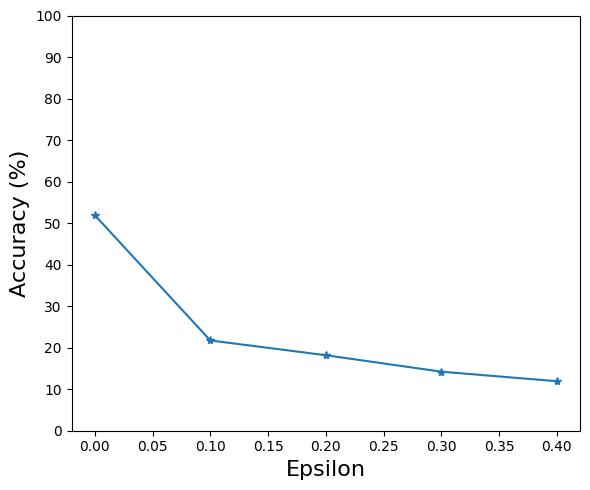

In [ ]:
plt.figure(figsize=(6,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 101, step=10))
# plt.xticks(epsilons)
# plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon", fontsize=16)
plt.ylabel("Accuracy (%)", fontsize=16)
# plt.grid(True, color='gray')
plt.tight_layout()
# plt.tick_params(axis='both', labelsize=14)  # Set tick label size for both axes
plt.show()

Plot several examples of adversarial samples for each epsilon.

In [ ]:
adversarials = create_adversarials(model, testloader_adv, 0.4)

adv_data = torch.FloatTensor(adversarials['adv_examples'])
adv_targets = torch.LongTensor(adversarials['targets'])

advdataset = CustomTensorDataset(tensors=(adv_data, adv_targets), transform=None)
advloader = DataLoader(advdataset, batch_size=batch_size_test, shuffle=False, num_workers=0)

In [ ]:
test_acc = test_final(model, advloader); test_acc


Test set: Avg. loss: 0.087066, Accuracy: 596/5000 (11.92%)



11.92

# Deep kNN

In [ ]:
class NearestNeighbor:

    class BACKEND(enum.Enum):
        FALCONN = 1
        FAISS = 2

    def __init__(self, backend, dimension, neighbors, number_bits, nb_tables=None):
        assert backend in NearestNeighbor.BACKEND

        self._NEIGHBORS = neighbors
        self._BACKEND = backend

        if self._BACKEND is NearestNeighbor.BACKEND.FALCONN:
            self._init_falconn(dimension, number_bits, nb_tables)
        elif self._BACKEND is NearestNeighbor.BACKEND.FAISS:
            self._init_faiss(dimension)
        else:
            raise NotImplementedError

    def _init_falconn(self, dimension, number_bits, nb_tables):
        assert nb_tables >= self._NEIGHBORS

        # LSH parameters
        params_cp = falconn.LSHConstructionParameters()
        params_cp.dimension = dimension
        params_cp.lsh_family = falconn.LSHFamily.CrossPolytope
        params_cp.distance_function = falconn.DistanceFunction.EuclideanSquared
        params_cp.l = nb_tables
        params_cp.num_rotations = 2  # for dense set it to 1; for sparse data set it to 2
        params_cp.seed = 5721840
        params_cp.num_setup_threads = 0  # we want to use all the available threads to set up
        params_cp.storage_hash_table = falconn.StorageHashTable.BitPackedFlatHashTable

        # we build number_bits-bit hashes so that each table has
        # 2^number_bits bins; a rule of thumb is to have the number
        # of bins be the same order of magnitude as the number of data points
        falconn.compute_number_of_hash_functions(number_bits, params_cp)
        self._falconn_table = falconn.LSHIndex(params_cp)
        self._falconn_query_object = None
        self._FALCONN_NB_TABLES = nb_tables

    def _init_faiss(self, dimension):
        res = faiss.StandardGpuResources()
        self._faiss_index = faiss.GpuIndexFlatL2(res, dimension)

    def add(self, x):
        if self._BACKEND is NearestNeighbor.BACKEND.FALCONN:
            self._falconn_table.setup(x)
        elif self._BACKEND is NearestNeighbor.BACKEND.FAISS:
            self._faiss_index.add(x)
        else:
            raise NotImplementedError

    def find_knns(self, x, output):
        if self._BACKEND is NearestNeighbor.BACKEND.FALCONN:
            return self._find_knns_falconn(x, output)
        elif self._BACKEND is NearestNeighbor.BACKEND.FAISS:
            return self._find_knns_faiss(x, output)
        else:
            raise NotImplementedError

    def _find_knns_falconn(self, x, output):
        # Late falconn query_object construction
        # Since I suppose there might be an error
        # if table.setup() will be called after
        if self._falconn_query_object is None:
            self._falconn_query_object = self._falconn_table.construct_query_object()
            self._falconn_query_object.set_num_probes(self._FALCONN_NB_TABLES)

        missing_indices = np.zeros(output.shape, dtype=bool)

        for i in range(x.shape[0]):
            query_res = self._falconn_query_object.find_k_nearest_neighbors(x[i], self._NEIGHBORS)

            try:
                output[i, :] = query_res
            except:
                # mark missing indices
                missing_indices[i, len(query_res):] = True
                output[i, :len(query_res)] = query_res

        return missing_indices

    def _find_knns_faiss(self, x, output):
        neighbor_distance, neighbor_index = self._faiss_index.search(x, self._NEIGHBORS)

        missing_indices = neighbor_distance == -1
        d1 = neighbor_index.reshape(-1)

        output.reshape(-1)[np.logical_not(missing_indices.flatten())] = d1[np.logical_not(missing_indices.flatten())]

        return missing_indices


class DkNN:

    def __init__(self, model, nb_classes, neighbors, layers, trainloader, nearest_neighbor_backend, nb_tables=200, number_bits=17):
        """
        Implementation of the DkNN algorithm, see https://arxiv.org/abs/1803.04765 for more details
        :param model: model to be used
        :param nb_classes: the number of classes in the task
        :param neighbors: number of neighbors to find per layer
        :param layers: a list of layer names to include in the DkNN
        :param trainloader: data loader for the training data
        :param nearest_neighbor_backend: falconn or faiss to be used for LSH
        :param nb_tables: number of tables used by FALCONN to perform locality-sensitive hashing.
        :param number_bits: number of hash bits used by LSH.
        """
        print('---------- DkNN init')
        print()

        self.model = model
        self.nb_classes = nb_classes
        self.neighbors = neighbors
        self.layers = layers
        self.backend = nearest_neighbor_backend
        self.nb_tables = nb_tables
        self.number_bits = number_bits

        self.nb_cali = -1
        self.calibrated = False

        # Compute training data activations
        activations = get_activations(trainloader, model, layers)
        self.train_activations = activations['activations']
        self.train_labels = activations['targets']

        # Build locality-sensitive hashing tables for training representations
        self.train_activations_lsh = copy.copy(self.train_activations)
        self.init_lsh()

    def init_lsh(self):
        """
        Initializes locality-sensitive hashing with FALCONN to find nearest neighbors in training data
        """
        self.query_objects = {} # contains the object that can be queried to find nearest neighbors at each layer
        self.centers = {} # mean of training data representation per layer (that needs to be substracted before NearestNeighbor)

        print("## Constructing the NearestNeighbor tables")

        for layer in self.layers:
            print("Constructing table for {}".format(layer))

            # Normalize all the lenghts, since we care about the cosine similarity
            self.train_activations_lsh[layer] /= np.linalg.norm(self.train_activations_lsh[layer], axis=1).reshape(-1, 1)

            # Center the dataset and the queries: this improves the performance of LSH quite a bit
            center = np.mean(self.train_activations_lsh[layer], axis=0)
            self.train_activations_lsh[layer] -= center
            self.centers[layer] = center

            # Constructing nearest neighbor table
            self.query_objects[layer] = NearestNeighbor(
                backend=self.backend,
                dimension=self.train_activations_lsh[layer].shape[1],
                number_bits=self.number_bits,
                neighbors=self.neighbors,
                nb_tables=self.nb_tables,
            )

            self.query_objects[layer].add(self.train_activations_lsh[layer])

        print("done!")
        print()


    def calibrate(self, calibloader):
        """
        Runs the DkNN on holdout data to calibrate the credibility metric
        :param calibloader: data loader for the calibration loader
        """
        print('---------- DkNN calibrate')
        print()

        # Compute calibration data activations
        self.nb_cali = len(calibloader.dataset)
        activations = get_activations(calibloader, self.model, self.layers)
        self.cali_activations = activations['activations']
        self.cali_labels = activations['targets']

        print("## Starting calibration of DkNN")

        cali_knns_ind, cali_knns_labels = self.find_train_knns(self.cali_activations)
        assert all([v.shape == (self.nb_cali, self.neighbors) for v in cali_knns_ind.values()])
        assert all([v.shape == (self.nb_cali, self.neighbors) for v in cali_knns_labels.values()])

        cali_knns_not_in_class = self.nonconformity(cali_knns_labels)
        cali_knns_not_in_l = np.zeros(self.nb_cali, dtype=np.int32)

        for i in range(self.nb_cali):
            cali_knns_not_in_l[i] = cali_knns_not_in_class[i, self.cali_labels[i]]

        cali_knns_not_in_l_sorted = np.sort(cali_knns_not_in_l)
        self.cali_nonconformity = np.trim_zeros(cali_knns_not_in_l_sorted, trim='f')
        self.nb_cali = self.cali_nonconformity.shape[0]
        self.calibrated = True

        print("DkNN calibration complete")

    def find_train_knns(self, data_activations):
        """
        Given a data_activation dictionary that contains a np array with activations for each layer,
        find the knns in the training data
        """
        knns_ind = {}
        knns_labels = {}

        for layer in self.layers:
            # Pre-process representations of data to normalize and remove training data mean
            data_activations_layer = copy.copy(data_activations[layer])
            nb_data = data_activations_layer.shape[0]
            data_activations_layer /= np.linalg.norm(data_activations_layer, axis=1).reshape(-1, 1)
            data_activations_layer -= self.centers[layer]

            # Use FALCONN to find indices of nearest neighbors in training data
            knns_ind[layer] = np.zeros((data_activations_layer.shape[0], self.neighbors), dtype=np.int32)
            knn_errors = 0

            knn_missing_indices = self.query_objects[layer].find_knns(data_activations_layer, knns_ind[layer])
            knn_errors += knn_missing_indices.flatten().sum()

            # Find labels of neighbors found in the training data
            knns_labels[layer] = np.zeros((nb_data, self.neighbors), dtype=np.int32)

            knns_labels[layer].reshape(-1)[
                np.logical_not(knn_missing_indices.flatten())
            ] = self.train_labels[
                knns_ind[layer].reshape(-1)[np.logical_not(knn_missing_indices.flatten())]
            ]

        return knns_ind, knns_labels

    def nonconformity(self, knns_labels):
        """
        Given an dictionary of nb_data x nb_classes dimension, compute the nonconformity of
        each candidate label for each data point: i.e. the number of knns whose label is
        different from the candidate label
        """
        nb_data = knns_labels[list(self.layers.keys())[0]].shape[0]
        knns_not_in_class = np.zeros((nb_data, self.nb_classes), dtype=np.int32)

        for i in range(nb_data):
            # Compute number of nearest neighbors per class
            knns_in_class = np.zeros((len(self.layers), self.nb_classes), dtype=np.int32)

            for layer_id, layer in enumerate(self.layers):
                knns_in_class[layer_id, :] = np.bincount(knns_labels[layer][i], minlength=self.nb_classes)

            # Compute number of knns in other class than class_id
            for class_id in range(self.nb_classes):
                knns_not_in_class[i, class_id] = np.sum(knns_in_class) - np.sum(knns_in_class[:, class_id])

        return knns_not_in_class

    def fprop(self, testloader):
        """
        Performs a forward pass through the DkNN on an numpy array of data
        """
        print('---------- DkNN predict')
        print()

        if not self.calibrated:
            raise ValueError("DkNN needs to be calibrated by calling DkNNModel.calibrate method once before inferring")

        # Compute test data activations
        activations = get_activations(testloader, self.model, self.layers)
        data_activations = activations['activations']
        _, knns_labels = self.find_train_knns(data_activations)

        # Calculate nonconformity
        knns_not_in_class = self.nonconformity(knns_labels)
        print('Nonconformity calculated')

        # Create predictions, confidence and credibility
        _, _, creds = self.preds_conf_cred(knns_not_in_class)
        print('Predictions created')

        return creds, activations['targets']

    def preds_conf_cred(self, knns_not_in_class):
        """
        Given an array of nb_data x nb_classes dimensions, use conformal prediction to compute
        the DkNN's prediction, confidence and credibility
        """
        nb_data = knns_not_in_class.shape[0]
        preds_knn = np.zeros(nb_data, dtype=np.int32)
        confs = np.zeros((nb_data, self.nb_classes), dtype=np.float32)
        creds = np.zeros((nb_data, self.nb_classes), dtype=np.float32)

        for i in range(nb_data):
            # p-value of test input for each class
            p_value = np.zeros(self.nb_classes, dtype=np.float32)

            for class_id in range(self.nb_classes):
                # p-value of (test point, candidate label)
                p_value[class_id] = (float(self.nb_cali) - bisect_left(self.cali_nonconformity, knns_not_in_class[i, class_id])) / float(self.nb_cali)

            preds_knn[i] = np.argmax(p_value)
            confs[i, preds_knn[i]] = 1. - np.sort(p_value)[-2]
            creds[i, preds_knn[i]] = p_value[preds_knn[i]]

        # print(preds_knn)
        # print(confs)
        # print(creds)

        return preds_knn, confs, creds


def plot_reliability_diagram(confidence, labels, dataset_name):
    """
    Takes in confidence values (e.g. output of softmax or DkNN confidences) for
    predictions and correct labels for the data, plots a reliability diagram
    :param confidence: nb_samples x nb_classes with confidence scores
    :param labels: targets
    """
    assert len(confidence.shape) == 2
    assert len(labels.shape) == 1
    assert confidence.shape[0] == labels.shape[0]

    if confidence.max() <= 1.:
        # confidence array is output of softmax
        bins_start = [b / 10. for b in range(0, 10)]
        bins_end = [b / 10. for b in range(1, 11)]
        bins_center = [(b + .5) / 10. for b in range(0, 10)]
        preds_conf = np.max(confidence, axis=1)
        preds_l = np.argmax(confidence, axis=1)
    else:
        raise ValueError('Confidence values go above 1')

    print(preds_conf.shape, preds_l.shape)

    # Create var for reliability diagram (Will contain mean accuracies for each bin)
    reliability_diag = []
    num_points = []  # keeps the number of points in each bar

    # Find average accuracy per confidence bin
    for bin_start, bin_end in zip(bins_start, bins_end):
        above = preds_conf >= bin_start

        if bin_end == 1.:
            below = preds_conf <= bin_end
        else:
            below = preds_conf < bin_end

        mask = np.multiply(above, below)
        num_points.append(np.sum(mask))

        bin_mean_acc = max(0, np.mean(preds_l[mask] == labels[mask]))
        reliability_diag.append(bin_mean_acc)

    # Plot diagram
    assert len(reliability_diag) == len(bins_center)

    fig, ax1 = plt.subplots()
    _ = ax1.bar(bins_center, reliability_diag, width=.1, alpha=0.8, edgecolor = "black")
    plt.xlim([0, 1.])
    ax1.set_ylim([0, 1.])
    # Adding grid lines
    ax1.grid(True, which='both', axis='both', linestyle='--', color='gray')  # Add grid lines

    ax2 = ax1.twinx()
    ax2.plot(bins_center, num_points, color='r', linestyle='-', linewidth=7.0)
    ax2.set_ylabel('Number of data points', fontsize=16, color='r')

    if len(np.argwhere(confidence[0] != 0.)) == 1:
        # This is a DkNN diagram
        ax1.set_xlabel('Prediction Credibility', fontsize=16)

    else:
        # This is a softmax diagram
        ax1.set_xlabel('Prediction Confidence', fontsize=16)

    ax1.set_ylabel('Prediction Accuracy', fontsize=16)
    ax1.tick_params(axis='both', labelsize=14)
    ax2.tick_params(axis='both', labelsize=14, colors='r')
    fig.tight_layout()


    plots_folder = '/content/drive/My Drive/datasets/plots_Boston5G_combined'
    # Create the directory if it doesn't exist
    os.makedirs(plots_folder, exist_ok=True)
    pdf_plot_path = os.path.join(plots_folder, f'{dataset_name}_reliability_plot.pdf')
    plt.savefig(pdf_plot_path, format='pdf', dpi=600, bbox_inches='tight')
    plt.show()



Let's create a dataloader for training data that should be used to initialize the DkNN (shuffle must be false!). Then, initialize the DkNN.

In [ ]:
# Create training data loader for DkNN
trainloader_dknn = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size_train, shuffle=False, num_workers=0
)

# Initialize DkNN
nb_classes_mnist = 128
dknn = DkNN(model, nb_classes_mnist, neighbors, layers, trainloader_dknn, NearestNeighbor.BACKEND.FALCONN)

---------- DkNN init

## Fetching Activations from Layer relu1
done!

## Fetching Activations from Layer relu2


<ipython-input-18-a703ea14c9c5>:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = [torch.tensor(item) for item in batch]


done!

## Fetching Activations from Layer relu3
done!

## Fetching Activations from Layer fc
done!

## Constructing the NearestNeighbor tables
Constructing table for relu1
Constructing table for relu2
Constructing table for relu3
Constructing table for fc
done!



Then, calibrate.

In [ ]:
dknn.calibrate(calibloader)

---------- DkNN calibrate

## Fetching Activations from Layer relu1
done!

## Fetching Activations from Layer relu2
done!

## Fetching Activations from Layer relu3
done!

## Fetching Activations from Layer fc
done!

## Starting calibration of DkNN


<ipython-input-18-a703ea14c9c5>:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = [torch.tensor(item) for item in batch]


DkNN calibration complete


Create DkNN predictions for the test set.

In [ ]:
dknn_preds_testset, test_targets = dknn.fprop(testloader)

print()
print('---------------------------------------------')
print('preds:   {}'.format(dknn_preds_testset.shape))
print('targets: {}'.format(test_targets.shape))

---------- DkNN predict

## Fetching Activations from Layer relu1
done!

## Fetching Activations from Layer relu2
done!

## Fetching Activations from Layer relu3
done!


<ipython-input-18-a703ea14c9c5>:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = [torch.tensor(item) for item in batch]



## Fetching Activations from Layer fc
done!

Nonconformity calculated
Predictions created

---------------------------------------------
preds:   (5000, 128)
targets: (5000,)


(5000,) (5000,)


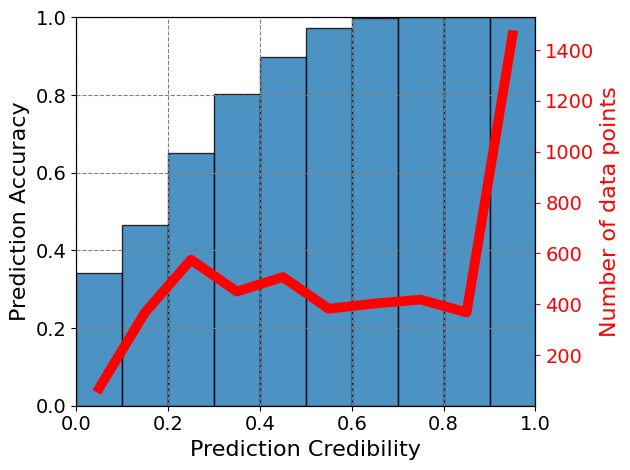

In [ ]:
with warnings.catch_warnings():
  warnings.simplefilter("ignore", category=RuntimeWarning)
  plot_reliability_diagram(dknn_preds_testset, test_targets, dataset_name = 'DkNN_test_data')

Create DkNN predictions for the adversarial set.

In [ ]:

dknn_preds_advset, adv_targets = dknn.fprop(advloader)

print()
print('---------------------------------------------')
print('preds:   {}'.format(dknn_preds_advset.shape))
print('targets: {}'.format(test_targets.shape))

---------- DkNN predict

## Fetching Activations from Layer relu1
done!

## Fetching Activations from Layer relu2
done!

## Fetching Activations from Layer relu3
done!


<ipython-input-18-a703ea14c9c5>:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = [torch.tensor(item) for item in batch]



## Fetching Activations from Layer fc
done!

Nonconformity calculated
Predictions created

---------------------------------------------
preds:   (5000, 128)
targets: (5000,)


Let's plot the result.

(5000,) (5000,)


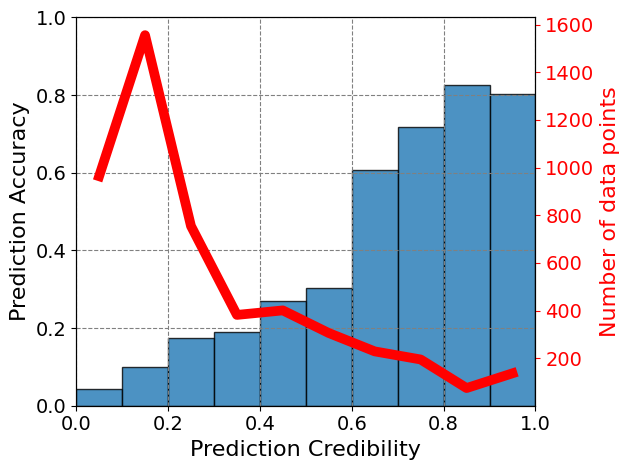

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    plot_reliability_diagram(dknn_preds_advset, adv_targets,  dataset_name = 'DkNN_adv_data' )

## Softmax Classider and reliabaility

For comparision let us also create the plot using the softmax scores instead of the DkNN scores.

In [ ]:
def get_softmax_scores(model, dataloader):
    model.eval()
    softmax_scores = []

    with torch.no_grad():
        for data in dataloader:
            # Get the inputs; data is a list of [inputs, labels]
            inputs, targets = data

            if use_cuda:
              inputs, targets = inputs.cuda(), targets.cuda()

            # Forward + loss + correct
            outputs = model(inputs)
            criterion(outputs, targets)

            # Get softmax scores
            softmax_output = torch.nn.functional.softmax(outputs.data, dim=1)
            pred, pred_idx = torch.max(softmax_output, 1)
            softmax_score = np.zeros((pred.shape[0],128), dtype=np.float32)  ## its the number of outputs

            pred = pred.detach().cpu().numpy()
            pred_idx = pred_idx.detach().cpu().numpy()

            softmax_score[np.arange(pred_idx.shape[0]), pred_idx] = pred
            softmax_scores.append(softmax_score)

    return np.vstack(softmax_scores)

Compute the softmax scores for the test set.

In [ ]:
softmax_scores_testset = get_softmax_scores(model, testloader); softmax_scores_testset.shape

(5000, 128)

Let's plot the result.

(5000,) (5000,)


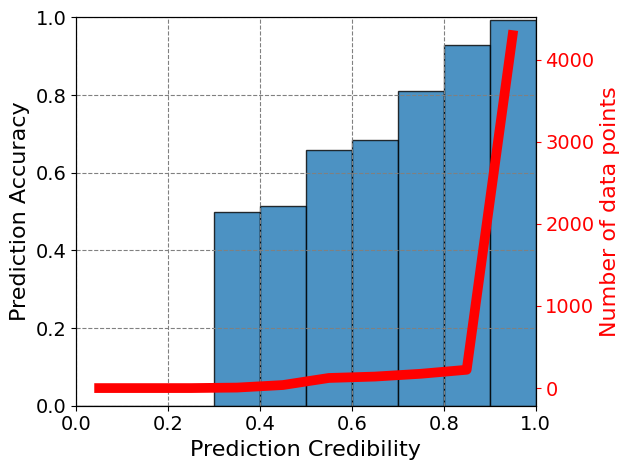

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    plot_reliability_diagram(softmax_scores_testset, test_targets,  dataset_name = 'softmax_test_data' )

Compute the softmax scores for the adverserial
 set.

In [ ]:
softmax_scores_advset = get_softmax_scores(model, advloader); softmax_scores_advset.shape

(5000, 128)

(5000,) (5000,)


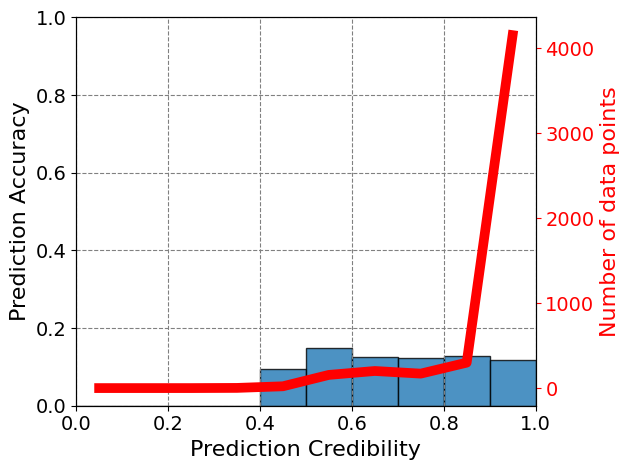

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    plot_reliability_diagram(softmax_scores_advset, adv_targets, dataset_name = 'softmax_adv_data')

## Combined reliability plot

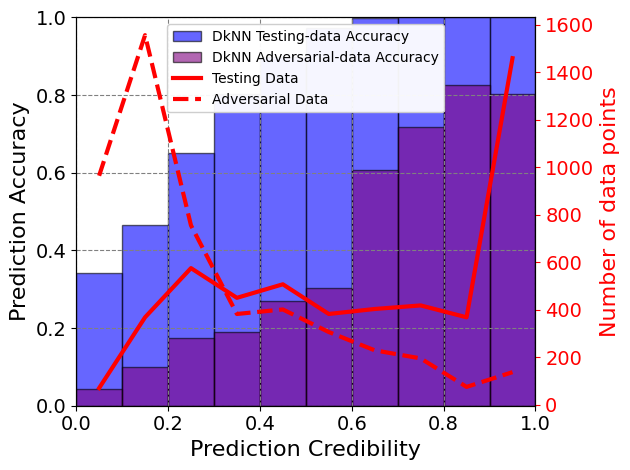

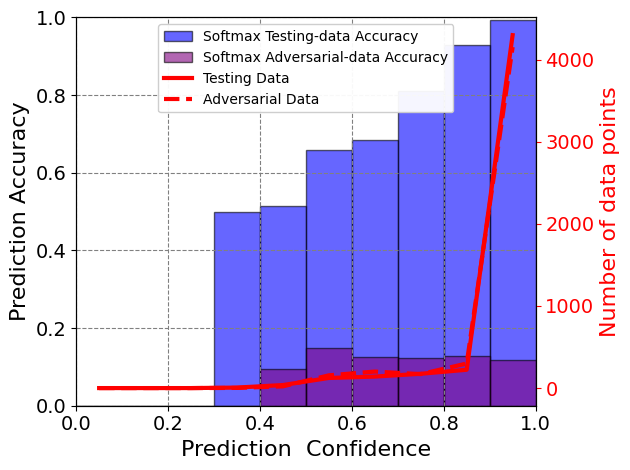

In [ ]:
def plot_combined_reliability_diagram(flag,dataset_name,confidence1, labels1, confidence2, labels2, dataset_names):
    """
    Plots overlaid reliability diagrams for two datasets: test and adversarial data.
    Bars are shown with transparency, so both are visible, and lines for the number
    of data points are plotted in solid and dotted red.
    :param confidence1: nb_samples x nb_classes for DkNN_test_data
    :param labels1: correct labels for test data
    :param confidence2: nb_samples x nb_classes for DkNN_adv_data
    :param labels2: correct labels for adversarial data
    :param dataset_names: List containing names of the datasets [test_name, adv_name]
    """
    def compute_reliability_diag(confidence, labels):
        bins_start = [b / 10. for b in range(0, 10)]
        bins_end = [b / 10. for b in range(1, 11)]
        bins_center = [(b + .5) / 10. for b in range(0, 10)]
        preds_conf = np.max(confidence, axis=1)
        preds_l = np.argmax(confidence, axis=1)

        reliability_diag = []
        num_points = []

        for bin_start, bin_end in zip(bins_start, bins_end):
            above = preds_conf >= bin_start
            below = preds_conf <= bin_end if bin_end == 1. else preds_conf < bin_end
            mask = np.multiply(above, below)

            num_points.append(np.sum(mask))
            bin_mean_acc = max(0, np.mean(preds_l[mask] == labels[mask]))
            reliability_diag.append(bin_mean_acc)

        return reliability_diag, num_points

    # Compute reliability diagrams for both datasets
    reliability_diag1, num_points1 = compute_reliability_diag(confidence1, labels1)
    reliability_diag2, num_points2 = compute_reliability_diag(confidence2, labels2)
    bins_center = [(b + .5) / 10. for b in range(0, 10)]

    fig, ax1 = plt.subplots()

    # Plot overlaid bars with transparency
    if flag==0:
      ax1.bar(bins_center, reliability_diag1, width=0.1, alpha=0.6, edgecolor='black', label=f'DkNN Testing-data Accuracy', color='blue')
      ax1.bar(bins_center, reliability_diag2, width=0.1, alpha=0.6, edgecolor='black', label=f'DkNN Adversarial-data Accuracy', color='purple')
    else:
        ax1.bar(bins_center, reliability_diag1, width=0.1, alpha=0.6, edgecolor='black', label=f'Softmax Testing-data Accuracy', color='blue')
        ax1.bar(bins_center, reliability_diag2, width=0.1, alpha=0.6, edgecolor='black', label=f'Softmax Adversarial-data Accuracy', color='purple')


    # Add grid lines
    ax1.grid(True, which='both', axis='both', linestyle='--', color='gray')

    ax1.set_xlim([0, 1.])
    ax1.set_ylim([0, 1.])
    if flag==1:
      ax1.set_xlabel('Prediction  Confidence', fontsize=16)
    else:
      ax1.set_xlabel('Prediction Credibility', fontsize=16)
    ax1.set_ylabel('Prediction Accuracy', fontsize=16)
    ax1.tick_params(axis='both', labelsize=14)

    # Plot the number of points for both datasets
    ax2 = ax1.twinx()
    line1, = ax2.plot(bins_center, num_points1, color='r', linestyle='-', linewidth=3.0, label='Testing Data ')
    line2, = ax2.plot(bins_center, num_points2, color='r', linestyle='--', linewidth=3.0, label='Adversarial Data')

    ax2.set_ylabel('Number of data points', fontsize=16, color='r')
    ax2.tick_params(axis='both', labelsize=14, colors='r')

    # Combine legends for both accuracy and data points
    lines = [line1, line2]
    all_lines = ax1.get_legend_handles_labels()[0] + lines
    all_labels = ax1.get_legend_handles_labels()[1] + [line1.get_label(), line2.get_label()]
    ax1.legend(all_lines, all_labels, loc='upper center',framealpha=0.95)

    fig.tight_layout()
    plots_folder = f'/content/drive/My Drive/datasets/plots/{dataset_name}_reliabilityplots'
    os.makedirs(plots_folder, exist_ok=True)
    pdf_plot_path = os.path.join(plots_folder, f'{dataset_name}_joint_reliability_{flag}.eps')
    plt.savefig(pdf_plot_path, format='eps', dpi=600, bbox_inches='tight')
    plt.show()



# Example usage with dataset names:


    # Create the directory if it doesn't exist
# dataset_name='Boston5G'
dataset_name='01-60'
if dataset_name=='Boston5G':
  flag=0
  plot_combined_reliability_diagram(flag,dataset_name,dknn_preds_testset, test_targets, dknn_preds_advset, adv_targets, ['DkNN_test_data', 'DkNN_adv_data'])
  flag=1
  plot_combined_reliability_diagram(flag,dataset_name, softmax_scores_testset, test_targets, softmax_scores_advset, adv_targets, ['softmax_test_data', 'softmax_adv_data'])

if dataset_name=='01-60':
   flag=0
   plot_combined_reliability_diagram(flag,dataset_name,dknn_preds_testset, test_targets, dknn_preds_advset, adv_targets, ['DkNN_test_data', 'DkNN_adv_data'])
   flag=1
   plot_combined_reliability_diagram(flag,dataset_name, softmax_scores_testset, test_targets, softmax_scores_advset, adv_targets, ['softmax_test_data', 'softmax_adv_data'])